# Anomaly Detection on Time Series via Robust Principal Component Analysis

This will be a short introduction on how to apply [Robust Principal Component Analysis (RPCA)][rpca] to detect anomalies on time series. We'll first generate synthetic data to test our implementation of RPCA and go on to apply the same approach to real world ad exchange data taken from the [Numenta Anomaly Benchmark (NAB)][nab].

[rpca]: https://en.wikipedia.org/wiki/Robust_principal_component_analysis
[nab]: https://numenta.com/applications/numenta-anomaly-benchmark/

## Robust Principal Component Analysis

Robust Principal Component Analysis (RPCA) is an extension of PCA, an unsupervised method for dimensionality reduction, widely used in scientific data analytics. While PCA projects the data into a smaller vectorspace along direction of highest variability, RPCA decomposes a $m \times n$ matrix $\mathbf{M}$ as the sum of low-rank component $\mathbf{A}$ (static signal or pattern) and sparse component $\mathbf{E}$ (outliers or noise), thus making it _robust_ to outliers.

![rpca components](./rpca.svg)

$$ 
\large \min_{\mathbf{A},\mathbf{E}} \|\mathbf{A}\|_{*} + \lambda \|\mathbf{E}\|_{1}, \quad \text{subject to} \quad \large \mathbf{A} + \mathbf{E} = \mathbf{M}
$$

$ \|\mathbf{A}\|_{*}$ is the nuclear norm, sum of singular values of $\mathbf{A}$

$ \|\mathbf{E}\|_{1}$ is $l_1$-norm, sum of absolute values of elements of $\mathbf{E}$

The solution can be recovered exactly if $\mathbf{A}$ is suffiecently low-rank but not sparse, and if $\mathbf{E}$ is likewise sufficiently sparse but not low-rank (relative to the rank of $\mathbf{A}$).

RPCA is predomanitly applied within computer vision applications (motion detection), where static background (low rank component) is separated from any temporary artefacts (sparse component). Pictured below is a sequence taken from a CCTV video [[Candes et al. 2009]][Candes2009]. Frames are stacked to each form a row in $\mathbf{M}$ (left). After decomposition we get the static background $\mathbf{A}$ (middle) and any temporary artefacts $\mathbf{E}$ (right).

![Motion Detection](./motion_detection.svg)

---

There are a number of methods to solve the optimization problem above. [Lin et al. (2009)][Lin2009] provide a review including:

* Principcal Component Pursuit
* Iterative Thresholding
* Accelerated Proximal Gradient
* __(Inexact) Augmented Lagrange Multipliers__
* Alternating Direction Method of Multipliers

Here we'll apply the more widely used (next to ADMM) IALM (~5x faster to e.g. APG).

[Candes2009]: http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf


### Augmented Lagrangian Method

Augmented Lagrange Multipliers is a general method for solving constrained optimization problems by replacing unconstrained problems with a series of unconstrained problems, while introducing a penalty to the objective. 

These problems are of the kind:

$$
\large \min f(\mathbf{X}), \quad \text{subject to} \quad h(\mathbf{X})=0 \\
$$

with the Lagrangian function defined as:
$$
\large L(\mathbf{X},\mathbf{Y},\mu) = f(\mathbf{X}) + \langle \mathbf{Y},h(\mathbf{X}) \rangle + \frac{\mu}{2} \|h(\mathbf{X})\|^2_F
$$

which we may apply to our problem above, resulting in:

$$ 
\large \mathbf{X} = (\mathbf{A},\mathbf{E}), \quad f(\mathbf{X}) = \|\mathbf{A}\|_* + \lambda \|\mathbf{E}\|_1, \quad h(\mathbf{X}) = \mathbf{M} - \mathbf{A} - \mathbf{E}
\\
\large L(\mathbf{A}, \mathbf{E}, \mathbf{Y}, \mu) ~ \dot = ~ \|\mathbf{A}\|_{*} + \lambda \|\mathbf{E}\|_1 + \langle \mathbf{Y}, \mathbf{M} - \mathbf{A} - \mathbf{E} \rangle + \frac{\mu}{2} \| \mathbf{M} - \mathbf{A} - \mathbf{E} \|^2_{F}
$$

For a more in-depth review, I highly recommend consulting [Lin et al. (2009)][Lin2009].

---

### Algorithm (IALM)

$
\begin{aligned}
&\text{Inputs:} ~ \bf{M}\\
\\
&\text{Initialize:} \\
&\qquad \bf{A} = 0, ~ \bf{E} = 0 \\
&\qquad \bf{Y}, ~ \mu \gt 0 \\
\\
&\text{While not converged do:}\\
&\qquad\bf{U},\bf{S},\bf{V} = \rm{SVD}(\bf{M} - \bf{E} + \bf{Y}/\mu) \\
&\qquad\bf{A} = \bf{U}\it{T}_{1/\mu}(\bf{S})\bf{V}^{\sf{T}} \\
&\qquad\bf{E} = \it{T}_{\lambda/\mu}(\bf{M} - \bf{A} - \bf{Y}/\mu) \\
&\qquad\text{Update} ~ \bf{Y} = \bf{Y} + \mu (\bf{M} - \bf{A} - \bf{E}) \\
\\
&\text{Outputs:} ~ \bf{A}, ~ \bf{E}
\end{aligned}
$

Where $ \it{T}_{\varepsilon} $ is the shrinkage operator.

$
\it{T}_{\varepsilon} (\bf{D}) = \arg \min_{\bf{X}} \varepsilon \|\bf{X}\|_1 + 
\frac{1}{2} \|\bf{X} - \bf{D}\|^2_{\it{F}}
$

### Typical initialization

$
\begin{aligned}
&sgn(\mathbf{X}) ~ \text{gives sign of each matrix element of} ~ \mathbf{X} \\
\\
&J(\cdot) ~ \text{gives scaling factors:} \\
&\qquad J(\mathbf{X}) = \text{max}(\|\mathbf{X}\|_{\mathrm{2}}, \lambda^{-1} \|\mathbf{X}\|_{\mathrm{∞}}) \\
\\
&\|\mathbf{X}\|_{\mathrm{2}} ~ \textrm{is the spectral norm of matrix} ~ \bf{X} \\
&\|\mathbf{X}\|_{\mathrm{∞}} ~ \textrm{is the largest absolute value of elements of matrix} ~ \bf{X} \\
\\
&\mathbf{Y} = sgn(\mathbf{M})/J(sgn(\mathbf{M})) \\
&\mu = 1.25 ~ \|\bf{M}\|_{\mathrm{2}} \\
&\lambda = 1 / \sqrt{\max{(m, n)}} ~ \text{for} ~ m \times n ~ \text{input matrix} ~
\bf{M}
\end{aligned}
$

---

[Lin2009]: https://arxiv.org/abs/1009.5055

### How does it work?
By solving the minimization problem, we decompose $\mathbf{M}$ into $\mathbf{A}$ and $\mathbf{E}$, where we minimize the rank of $\mathbf{A}$ (nuclear norm is a surrogate of the rank matrix rank, which can be thought of as convex relaxation of the number of non-zero eigenvalues), and panelize $\mathbf{E}$ for not being sufficiently sparse enough at the same time ($\ell_1$-norm).

### What does this mean for the circumenstances on when we can apply RPCA?
It suffices if the data is composed of largely linearly dependent vectors, and defects are rare (sparse, gaussian). Though outliers can be of any magnitude in comparision to PCA.

### Implementation

With all that out of the way, implementation is straight forward.

In [1]:
import sys

sys.path.append('./rpca')

In [2]:
# %load ./rpca/algorithm.py
"""
Robust Principal Component Analysis
"""

import numpy as np

from numpy.linalg import norm
from numpy.linalg import svd


def rpca_alm(M, mu=None, l=None, mu_tol=1E7, tol=1E-7, max_iter=1000):
    """Matrix recovery/decomposition using Robust Principal Component Analysis

    Decompose a rectengular matrix M into a low-rank component, and a sparse
    component, by solving a convex minimization problem via Augmented Lagrangian
    Method.

    minimize        ||A||_* + λ ||E||_1
    subject to      A + E = M

    where           ||A||_* is the nuclear norm of A (sum of singular values)
                        - surrogate of matrix rank
                    ||E||_1 is the l1 norm of E (absolute values of elements)
                        - surrogate of matrix sparseness

    Relaxed to

        L(A,E,Y,λ) .= ||A||_* + λ||E||_1 + <Y, M-A-E> + µ/2 ||M-A-E||_F^2

    Parameters
    ----------

    M : array-like, shape (n_samples, n_features)
        Matrix to decompose, where n_samples in the number of samples and
        n_features is the number of features.

    l : float (default 1/sqrt(max(m,n)), for m x n of M)
        Parameter λ (lambda) of the convex problem ||A||_* + λ ||E||_1. [2]_

    mu : float (default 1.25 * ||M||_2)
        Parameter µ (mu) of the Augmented Lagrange Multiplier form of Principal
        Component Pursuit (PCP). [2]_

    mu_tol : float >= 0 (default 1E-7)
        Weight parameter.

    tol : float >= 0 (default 1E-7)
        Tolerance for accuracy of matrix reconstruction of low rank and sparse
        components.

    max_iter : int >= 0 (default 1000)
        Maximum number of iterations to perform.

    Returns
    -------

    A : array, shape (n_samples, n_features)
        Low-rank component of the matrix decomposition.

    E : array, shape (n_samples, n_features)
        Sparse component of the matrix decomposition.

    err : float
        Error of matrix reconstruction
        ||M-A-E||_F / ||M||_F

    References
    ----------

    .. [1] Z. Lin, M. Chen, Y. Ma. The Augmented Lagrange Multiplier Method for
           Exact Recovery of Corrupted Low-Rank Matrices, arXiv:1009.5055

    .. [2] E. J. Candés, X. Li, Y. Ma, J. Wright. Robust principal
           component analysis? Journal of the ACM v.58 n.11 May 2011

    """

    rho = 1.5

    if not mu:
        mu = 1.25 * norm(M, ord=2)

    if not l:
        l = np.max(M.shape)**-.5

    M_sign = np.sign(M)
    norm_spectral = norm(M_sign, ord=2)
    norm_inf = norm(M_sign, ord=np.inf)
    norm_dual = np.max([norm_spectral, norm_inf * l**-1])

    Y = M_sign * norm_dual**-1
    A = np.zeros(M.shape)
    E = np.zeros(M.shape)

    err = np.inf
    i = 0

    while err > tol and i < max_iter:
        U, S, V = svd(M - E + Y * mu**-1, full_matrices=False)

        A = np.dot(U, np.dot(np.diag(_shrink(S, mu**-1)), V))
        E = _shrink(M - A + Y * mu**-1, l * mu**-1)
        Y = Y + mu * (M - A - E)

        err = _fro_error(M, A, E)
        mu *= rho
        mu = np.min([mu, mu_tol])
        i += 1

    return A, E, err


def _fro_error(M, A, E):
    """Error of matrix reconstruction"""
    return norm(M - A - E, ord='fro') * norm(M, ord='fro')**-1


def _shrink(M, t):
    """Shrinkage operator"""
    return np.sign(M) * np.maximum((np.abs(M) - t), np.zeros(M.shape))


### Wrapping into Sci-Kit Transformer

While we're at it, we're going to wrap our implementation into the sci-kit transformer base class, which will come in handy building future pipelines. This will serve only as quick scaffolding, to get us started and is not intended to be run in production.

In [3]:
# %load ./rpca/transformer.py
"""
Robust Principal Component Analysis Scikit-Learn transformer
"""

from sklearn.base import TransformerMixin

from algorithm import rpca_alm


class RobustPCA(TransformerMixin):
    """Matrix recovery/decomposition using Robust Principal Component Analysis

    Decompose a rectengular matrix M into a low-rank component, and a sparse
    component, by solving a convex minimization problem via Augmented Lagrangian
    Method.

    minimize        ||A||_* + λ ||E||_1
    subject to      A + E = M

    where           ||A||_* is the nuclear norm of A (sum of singular values)
                        - surrogate of matrix rank
                    ||E||_1 is the l1 norm of E (absolute values of elements)
                        - surrogate of matrix sparseness

    Relaxed to

        L(A,E,Y,λ) .= ||A||_* + λ||E||_1 + <Y, M-A-E> + µ/2 ||M-A-E||_F^2

    Parameters
    ----------

    M : array-like, shape (n_samples, n_features)
        Matrix to decompose, where n_samples in the number of samples and
        n_features is the number of features.

    l : float (default 1/sqrt(max(m,n)), for m x n of M)
        Parameter (lambda) of the convex problem ||A||_* + λ ||E||_1. [2]_

    mu : float (default 1.25 * ||M||_2)
        Parameter (mu) from the Augmented Lagrange Multiplier form of Principal
        Component Pursuit (PCP). [2]_

    mu_tol : float >= 0 (default 1E-7)
        Weight parameter.

    tol : float >= 0 (default 1E-7)
        Tolerance for accuracy of matrix reconstruction of low rank and sparse
        components.

    max_iter : int >= 0 (default 1000)
        Maximum number of iterations to perform.

    Attributes
    ----------

    low_rank_ : array, (n_samples, n_features)
        Low-rank component of the matrix decomposition.

    sparse_ : array, (n_samples, n_features)
        Sparse component of the matrix decomposition.

    error_ : float
        Error of matrix reconstruction
        ||M-A-E||_F / ||M||_F

    References
    ----------

    .. [1] Z. Lin, M. Chen, Y. Ma. The Augmented Lagrange Multiplier Method for
           Exact Recovery of Corrupted Low-Rank Matrices, arXiv:1009.5055

    .. [2] E. J. Candés, X. Li, Y. Ma, J. Wright. Robust principal
           component analysis? Journal of the ACM v.58 n.11 May 2011

    """

    def __init__(self, method='sparse',
                 l=None,
                 mu=None,
                 mu_tol=1E7,
                 tol=1E-7,
                 max_iter=1000):

        options = ['sparse', 'low_rank']

        if method not in options:
            raise ValueError(f'method must be one of {options}')

        self._method = method
        self._l = l
        self._mu = mu
        self._mu_tol = mu_tol
        self._tol = tol

        self.low_rank_ = None
        self.sparse_ = None
        self.error_ = None

    def transform(self, X):
        """Matrix decomposition/recovery with RPCA and ALM

        Parameters
        ----------

        X : array-like, shape (n_samples, n_features)
            Matrix to decompose, where n_samples in the number of samples and
            n_features is the number of features.

        Returns
        -------

        X_new : array-like, shape (n_samples, n_features)
            Decomposed matrix, either sparse component (method `sparse`) or
            low-rank component (method `low_rank`)
        """
        self.low_rank_, self.sparse_, self.error_ = rpca_alm(X,
                                                             mu=self._mu,
                                                             l=self._l,
                                                             mu_tol=self._mu_tol,
                                                             tol=self._tol)
        if self._method == 'sparse':
            return self.sparse_
        elif self._method == 'low_rank':
            return self.low_rank_
        else:
            raise ValueError('unknown method')


## Testing on synthetic data

Although RPCA being an inherently unsupervised method, we can benchmark accuracy if we are lucky enough to find a dedicated dataset which qualifies for our application/domain. In 2015 [Yahoo introduced a test set][yahoobench] specifically to benchmark anomaly detection on time series. Unfortunately it is only available to owners of an .edu email address. So this will be left to the reader, evaluating their RPCA implementation on the labeled data Yahoo provides.  

So for this exercise we'll have to generate our own time series and defects.  
For our purpose we want a time series with known anomalies that at the same time presents a challenge for conventional filtering approaches. 

What are non-trivial challenges for threshold/average based methods for outlier detection?

* seasonality
* trend
* noise

So ideally our test series would have some sort of seasonal recurring characteristic. We can think of a metric that is e.g. correlated to the time of day, similar to water consumption or sales/traffic within a region/timezone, etc pp.

Let's create one.

[yahoobench]: https://research.yahoo.com/news/announcing-benchmark-dataset-time-series-anomaly-detection

In [4]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [6]:
try:
    plt.style.use('markow')
except:
    plt.style.use('ggplot')

PLTARGS = {'figsize': (12, 6)}

In [7]:
N_SAMPLES = 100
FREQUENCY = 3

pattern = np.array([np.sin(2.0 * np.pi * FREQUENCY * N_SAMPLES**-1 * n) for n in range(N_SAMPLES+1)])

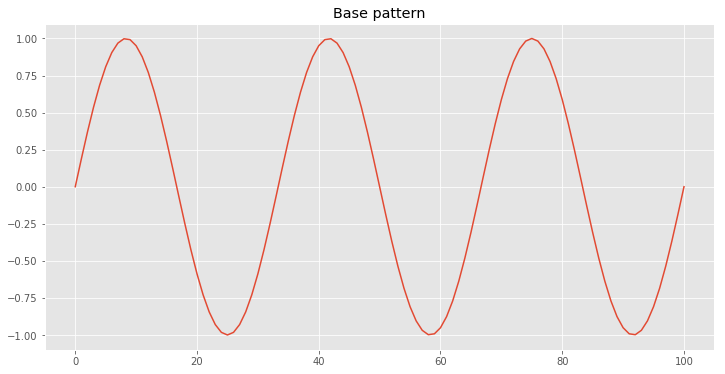

In [53]:
plt.figure(**PLTARGS)
plt.title('Base pattern')
plt.plot(pattern);

Voila, a basic sinusoidal signal, which will function as our base pattern.

In the real world we'll have to deal with noisy signals, so we're going to add a bit of gaussian noise. In addition we modulate the amplitude and randomly shift the mean of each sample, to showcase we only need the resulting matrix of our stacked dummy signals to be sufficiently low rank (linear dependent row vectors).

Since we want to be able to reproduce our setup in the future we're going to fix it (seeding our random number generator). Everytime someone in our team runs this notebook it'll yield the same output. 

In [9]:
np.random.seed(seed=456733626)

In [10]:
N_SENSORS = 100
AMPLITUDE = (10, 40)
YSHIFT = (50, 100)
SIGMA = 3
MU = 0

gauss_range = lambda x: np.random.rand() * (x[1]-x[0]) + x[0]

sensors = np.zeros((N_SENSORS, N_SAMPLES+1))

for i in range(N_SENSORS):
    noise = np.random.randn(N_SAMPLES+1) * SIGMA + MU
    signal = pattern * gauss_range(AMPLITUDE) + gauss_range(YSHIFT)
    sensors[i,:] = np.add(signal, noise)
    
sensor_names = np.array([f'sensor{n:03}' for n in range(1, N_SENSORS+1)])
    
df_sensors = pd.DataFrame(sensors.T, columns=sensor_names)

In [11]:
df_sensors.shape

(101, 100)

In [12]:
df_sensors.head(3)

,sensor001,sensor002,sensor003,sensor004,sensor005,sensor006,sensor007,sensor008,sensor009,sensor010,...,sensor091,sensor092,sensor093,sensor094,sensor095,sensor096,sensor097,sensor098,sensor099,sensor100
0,57.669753,55.402151,82.059911,101.330584,72.193168,76.323176,67.939596,55.209994,94.401344,63.896688,...,78.370841,51.074473,66.572422,82.071946,76.488259,61.076351,85.582060,73.741268,83.936137,59.517250
1,70.311771,52.085679,90.414549,104.836928,77.066970,81.631386,65.517215,55.104898,100.779719,69.845241,...,87.206179,60.980816,75.009266,89.267616,79.377751,67.464724,95.259478,74.283086,86.982747,64.620717
2,72.548859,58.951096,91.945815,109.998149,79.623673,98.080501,72.742849,56.607973,107.315154,74.671570,...,93.660543,57.301636,77.096759,89.065491,81.528715,73.127496,106.216898,77.758512,94.061979,65.970785


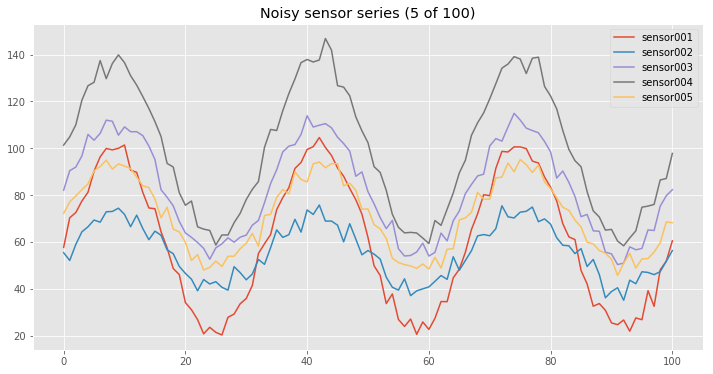

In [13]:
df_sensors.iloc[:, :5].plot(title='Noisy sensor series (5 of 100)', **PLTARGS);

To not only filter the noise, we need to introduce some defects.
Anomalies come in all kinds of shapes. Like with any ML approach, there's unlikely a method which outperforms all others in all scenarios. We have to consider where RPCA shines, and where it doesn't. It's particular good at finding deviations from an underlying, shared pattern. So we're going to introduce exactly that, short lived deviations from our base pattern. 

In [14]:
ANOMALY_DURATION = 10
ANOMALY_INTENSITY = 10

anomaly_map = np.random.rand(N_SENSORS) < 0.1

anomalies = np.zeros((N_SENSORS, N_SAMPLES+1))

for i, malign in enumerate(anomaly_map):
    if malign:
        onset = np.random.randint(N_SAMPLES - ANOMALY_DURATION)
        sign = -1 if np.random.randn() < 0.5 else 1
        noise = np.random.normal(0, 1, ANOMALY_DURATION) + ANOMALY_INTENSITY
        anomalies[i, onset:onset+ANOMALY_DURATION] = sign * noise

df_anomalies = pd.DataFrame(anomalies.T, columns=sensor_names)

In [15]:
df_anomalies.shape

(101, 100)

In [16]:
samples = np.where(anomaly_map)[0][:3]
print(sensor_names[samples])

['sensor002' 'sensor003' 'sensor011']


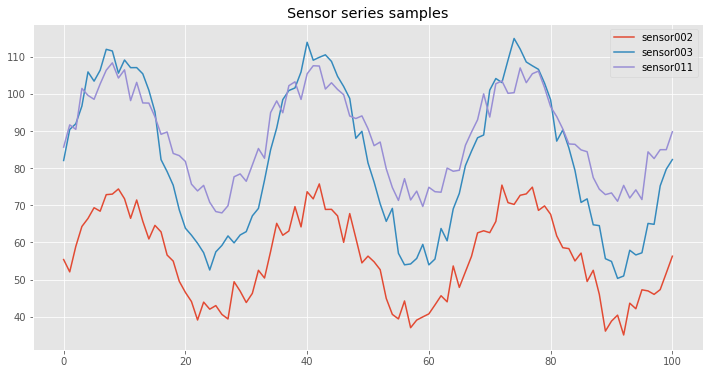

In [17]:
df_sensors.iloc[:, samples].plot(title='Sensor series samples', **PLTARGS);

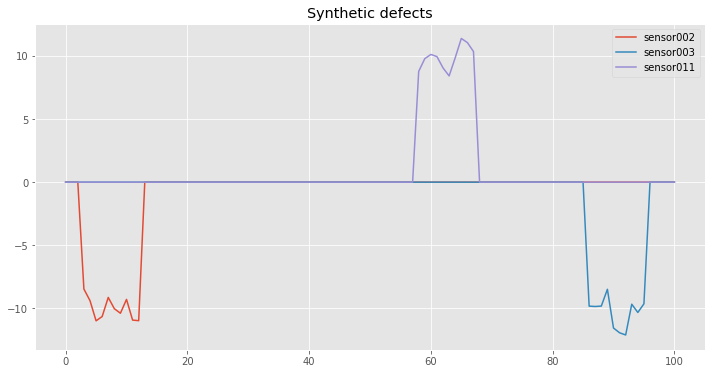

In [18]:
df_anomalies.iloc[:, samples].plot(title='Synthetic defects', **PLTARGS);

In [19]:
df_sensors_with_anomalies = df_sensors + df_anomalies

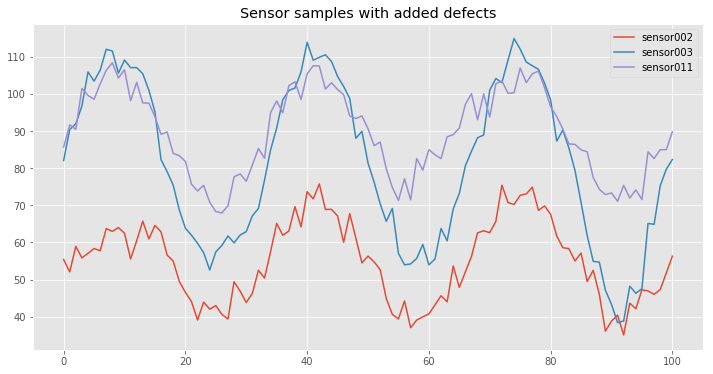

In [20]:
df_sensors_with_anomalies.iloc[:, samples].plot(title='Sensor samples with added defects', **PLTARGS);

Here we see the resulting signals.
Upon manual inspection, the defect on `sensor011` is hard to spot. Another case made for the need of reliable automated anomaly detection.

We're gonna center our input matrix (zero mean) to ensure we're projecting along the direction of maximum variance, and feed it into our RPCA implementation.
The result should be a sparse component solely made up of our generated defects and some noise, as well es a low-rank component containing the vanilla signals. 

In [21]:
values = StandardScaler(with_mean=True, with_std=False).fit_transform(df_sensors_with_anomalies.values.T)

In [22]:
model = RobustPCA(method='sparse', max_iter=1E5)

In [23]:
%%time

sparse_matrix = model.transform(values)

CPU times: user 19.6 ms, sys: 14.5 ms, total: 34.1 ms
Wall time: 14.8 ms


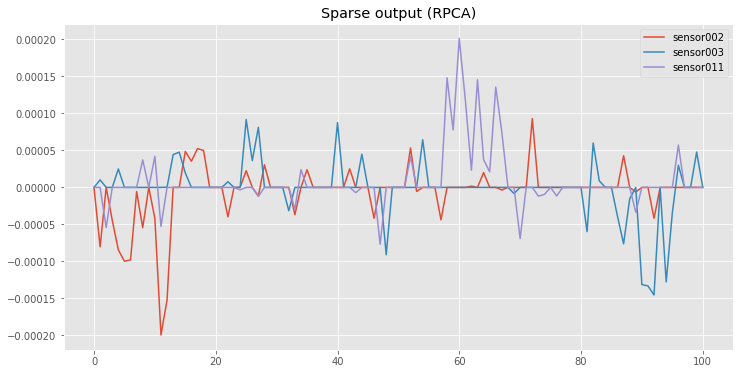

In [24]:
df_anomalies_estimated = pd.DataFrame(sparse_matrix.T, columns=sensor_names)
df_anomalies_estimated.iloc[:, samples].plot(title='Sparse output (RPCA)', **PLTARGS);

Exactly what we've expected. 

We could set a threshold here and be done, but what if the data, pattern or noise differs drastically e.g. in a different domain. An empirical threshold seems to be an insufficient and tedious approach if we want our method to be fully automated. But we can circumvent this by normalizing (zscore) the sparse component. We are now able to set a threshold based on the standard deviation (sigma), instead of the respective unit scale. In addition we consult the [three-sigma-rule][3sigma] for an initial threshold (sigma = 3). 

[3sigma]: https://en.wikipedia.org/wiki/68–95–99.7_rule

In [54]:
mean = np.mean(df_anomalies_estimated.values)
std = np.std(df_anomalies_estimated.values)

df_anomalies_zscore = (df_anomalies_estimated - mean) / std

In [55]:
THRESHOLD = 3

df_outliers = df_anomalies_zscore[(df_anomalies_zscore >= THRESHOLD) | (df_anomalies_zscore <= -THRESHOLD)]

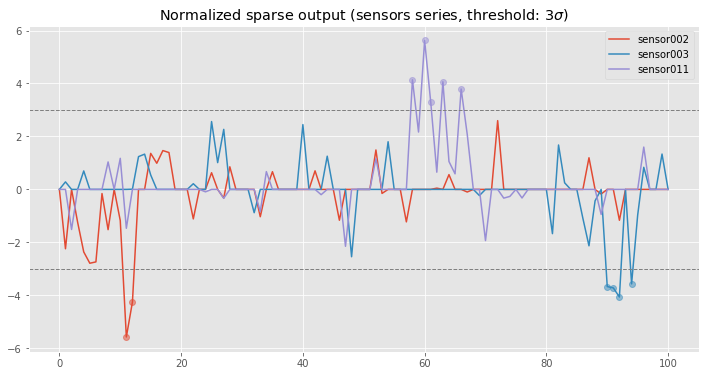

In [56]:
ax = df_anomalies_zscore.iloc[:, samples].plot(title=f'Normalized sparse output (sensors series, threshold: ${THRESHOLD}\sigma$)', 
                                               **PLTARGS)
ax.axhline(y=THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
ax.axhline(y=-THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
df_outliers.iloc[:, samples].plot(ax=ax, legend=False, linestyle='none', color=['C0', 'C1', 'C2'], marker="o", alpha=.5);

Here we are, fully automated anomaly detection based on RPCA.

Let's plot the original input data annotated along with the outliers we've just detected.

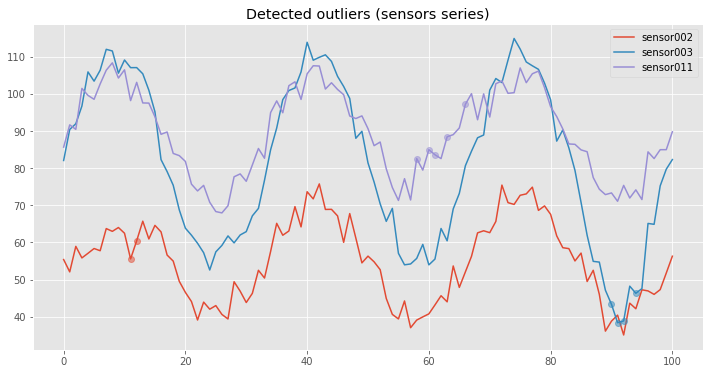

In [28]:
ax = df_sensors_with_anomalies.iloc[:, samples].plot(title='Detected outliers (sensors series)', **PLTARGS)
(df_sensors_with_anomalies[df_outliers.iloc[:, samples].isnull() == False]
    .iloc[:, samples]
    .plot(ax=ax, legend=False, linestyle='none', color=['C0', 'C1', 'C2'], marker="o", alpha=.5));

Where to go from here?

Well you can take this approach as is and add it to your anomaly detection suite. But you probably want to evaluate if RPCA in fact is reliably detecting true outliers (where as the definition of such can heavily differ depending on the application). It should be preceded by carefully analyzing the data, while utilizing any prior domain knowledge. 

You may be fortunate enough to have access to labeled data or can effort creating a large enough dataset of historical incidents (which you definitely should strive for), so you should be able to benchmark performance. But maintaining such a data set is a resource intensive task and requires constant reevaluation to cover potential edge cases.

RPCA is by no means the single solution to go with, but can be one (fully automated) method in a data workflow to successfuly detect, alert and subsequently mitigate incidents.

In addition it can provide an entry point for a stacked model approach, e.g. depending on the requirements, one could feed the sparse output into a recurrent model to discriminate between different anomaly categories, or mitigate false positive by incorporating additional environment factors.

## Evaluating on historic ad exchange data

[nab]: https://numenta.com/applications/numenta-anomaly-benchmark/

* https://github.com/numenta/NAB
* https://github.com/numenta/NAB/blob/master/data/realAdExchange/exchange-2_cpm_results.csv

In [29]:
!head -n 5 data/exchange-2_cpm_results.csv | tr ',' '\t'

timestamp	value
2011-07-01 00:00:01	0.401048098657
2011-07-01 01:00:01	0.392718881005
2011-07-01 02:00:01	0.309996119798
2011-07-01 03:00:01	0.212938552018


In [30]:
df_cpm = pd.read_csv('data/exchange-2_cpm_results.csv', index_col='date', names=['date', 'cpm'],
                     sep=',', parse_dates=True, header=0)

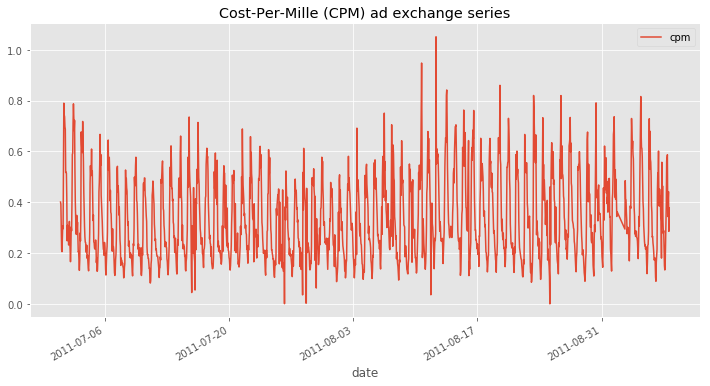

In [31]:
df_cpm.plot(title='Cost-Per-Mille (CPM) ad exchange series', **PLTARGS);

In [32]:
!sed -n '1500,1515p' data/exchange-2_cpm_results.csv | tr ',' '\t'

2011-09-01 14:00:01	0.412298289967
2011-09-01 15:00:01	0.490840855649
2011-09-01 16:00:01	0.428572872891
2011-09-01 17:00:01	0.344159041135
2011-09-01 18:00:01	0.362985835006
2011-09-02 15:00:01	0.29474600602
2011-09-02 16:00:01	0.485279887016
2011-09-02 17:00:01	0.41176305761
2011-09-02 18:00:01	0.410321629465
2011-09-02 19:00:01	0.361436552275
2011-09-02 20:00:01	0.330957212541
2011-09-02 21:00:01	0.276432333565
2011-09-02 22:00:01	0.291694292981
2011-09-02 23:00:01	0.301794690505
2011-09-03 00:00:01	0.291617242099
2011-09-03 01:00:01	0.277953194651


In [33]:
df_cpm = df_cpm.resample('1h').mean()

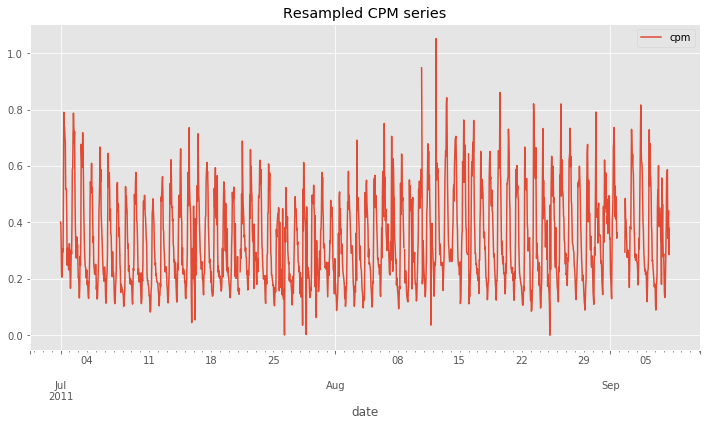

In [34]:
df_cpm.plot(title='Resampled CPM series', **PLTARGS);

In [35]:
df_cpm = df_cpm.interpolate(method='linear')

In [36]:
df_cpm['week'] = df_cpm.index.weekofyear
df_cpm['day'] = df_cpm.index.dayofweek
df_cpm['hour'] = df_cpm.index.hour

df_cpm_by_week = pd.pivot_table(df_cpm, index=['day', 'hour'], columns=['week'], values='cpm',
                           aggfunc=np.mean)

In [37]:
df_cpm_by_week.shape

(168, 11)

In [38]:
df_cpm_by_week.isnull().sum().sum()

200

In [39]:
df_cpm_by_week.isnull().sum()

week
26     96
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36    104
dtype: int64

In [40]:
df_cpm_by_week = df_cpm_by_week.dropna(axis=1, how='any')

In [41]:
df_cpm_by_week.shape

(168, 9)

In [42]:
df_cpm_by_week.isnull().sum().sum()

0

In [43]:
df_cpm_by_week.head()

week            27        28        29        30        31        32  \
day hour                                                               
0   0     0.179942  0.139389  0.225183  0.178073  0.183855  0.158421   
    1     0.192673  0.140955  0.161582  0.135347  0.146499  0.147071   
    2     0.166335  0.092254  0.150193  0.114143  0.136459  0.121540   
    3     0.142272  0.082216  0.138530  0.104570  0.087786  0.093912   
    4     0.130355  0.090850  0.139423  0.144247  0.113553  0.125770   

week            33        34        35  
day hour                                
0   0     0.219272  0.151385  0.148677  
    1     0.259993  0.136277  0.122675  
    2     0.112466  0.110605  0.109182  
    3     0.129890  0.106407  0.089285  
    4     0.184369  0.123629  0.124575

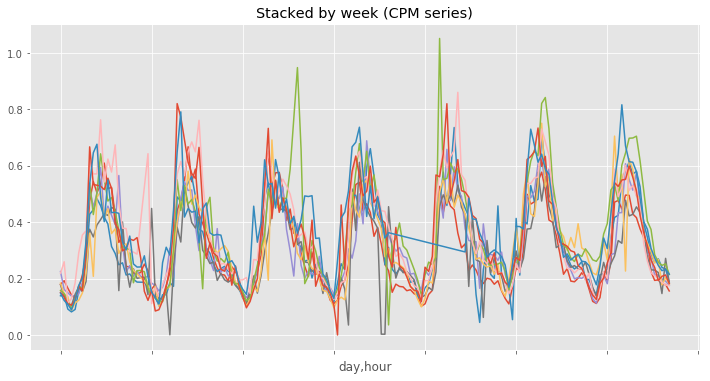

In [44]:
df_cpm_by_week.plot(title='Stacked by week (CPM series)', legend=False, **PLTARGS);

In [45]:
#df_cpm_by_week.T.to_csv('./data/cpm_weekly_clean.csv', header=False, index=False)

In [46]:
values = StandardScaler(with_mean=True, with_std=False).fit_transform(df_cpm_by_week.values)

In [47]:
%%time

cpm_sparse = model.transform(values)

CPU times: user 4.44 ms, sys: 765 µs, total: 5.2 ms
Wall time: 4.43 ms


In [48]:
cpm_mean = np.mean(cpm_sparse)
cpm_std = np.std(cpm_sparse)

cpm_sparse_zscore = (cpm_sparse - cpm_mean) / cpm_std

df_cpm_anomalies = pd.DataFrame(cpm_sparse_zscore, columns=df_cpm_by_week.columns, index=df_cpm_by_week.index)

In [49]:
THRESHOLD = 3

df_cpm_outliers = df_cpm_anomalies[(df_cpm_anomalies >= THRESHOLD) | (df_cpm_anomalies <= -THRESHOLD)]

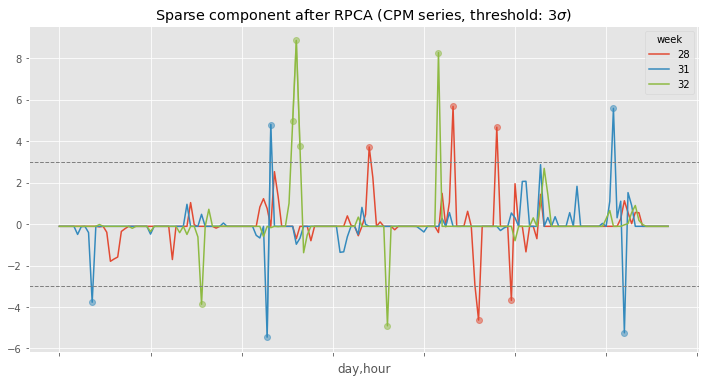

In [50]:
selected_weeks = [28, 31, 32]
colors = ['C0', 'C1', 'C5']

ax = df_cpm_anomalies[selected_weeks].plot(color=colors, **PLTARGS)
ax.axhline(y=THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
ax.axhline(y=-THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
df_cpm_outliers[selected_weeks].plot(title=f'Sparse component after RPCA (CPM series, threshold: ${THRESHOLD}\sigma$)', ax=ax, marker='o', color=colors,
                                     alpha=.5, linestyle=None, label='outlier', legend=False);

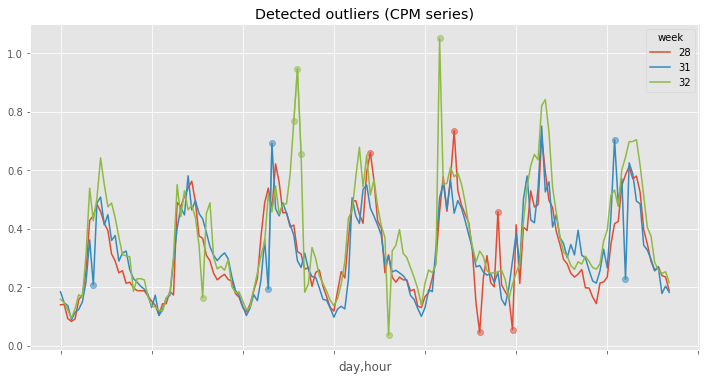

In [51]:
ax = df_cpm_by_week[selected_weeks].plot(color=colors, **PLTARGS)
df_cpm_by_week[df_cpm_outliers.isnull() == False][selected_weeks].plot(title='Detected outliers (CPM series)',
                                                                       ax=ax, marker='o', color=colors, alpha=.5, 
                                                                       linestyle=None, legend=False);

## Conclusion


### Where to go from here?

* online version
* stochastic version

## References

* Candès et al. (2009) [Robust Principal Component Analysis?][Candes2009]
* Lin et al. (2009) [The Augmented Lagrange Multiplier Method for Exact Recovery
  of Corrupted Low-Rank Matrices][Lin2009]
* [Anomaly Detection: Numenta Anomaly Benchmark][nab]


[Candes2009]: http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf
[Lin2009]: https://arxiv.org/abs/1009.5055
[nab]: https://numenta.com/applications/numenta-anomaly-benchmark/